In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Outline
1. Introduction \
    1.1 Aim of the project \
    1.2 Variables 
2. Methods \
    2.1 Data Preprocessing \
    2.2 Model selection \
    2.3 Evaluation metric
3. Experiments\
    3.1 Modeling with default parameters \
    3.2 Hyperparameter tuning
4. Analysis \
    4.1 Error analysis \
    4.2 Further experiments
5. Discussion
6. Conclusion

## 1. Introduction

### 1.1 Aim of the project

The following Project-2 continues with the investigation of red wine quality. As a recap, Project-1 was concerned about the relationship between red wine quality and its chemical properties. It contained a thorough data analysis that was trying to answer several research questions about the dataset. In this project, the aim is to construct a classification task that will predict the quality of red wine based on its chemical properties.

### 1.2 Variables

### Output variable 

The **quality** of wine was chosen to be as an output variable and there are multiple reasons for that:
1. In Project-1, it was mentioned that one can develop two different machine learning problems from the *red-wine dataset*. They are regression models (e.g. predicting the value of some chemical property) and classification models (e.g. predicting the quality of wine). For this project, the second machine learning problem was chosen because its solution seems to be more useful for customers. It is assumed that customers will be more interested in the quality of wine they are buying (based on chemical properties), rather than in the chemical properties of the wine (based on its quality);
2. A personal reason: I had a lot of experience with regression models, and now wanted to challenge myself and try something new.

### Input variables

*fixed acidity* - most acids involved with wine or fixed or nonvolatile (do not evaporate readily). <br>
*volatile acidity* -  the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste. <br>
*citric acid* - found in small quantities, citric acid can add ‘freshness’ and flavor to wines. <br>
*residual sugar* - the amount of sugar remaining after fermentation stops. <br>
*chlorides* - the amount of salt in the wine. <br>
*free sulfur dioxide* - the free form of $SO_2$ exists in equilibrium between molecular $SO_2$ and bisulfite ion; it prevents microbial growth and the oxidation of wine.<br>
*total sulfur dioxide* - amount of free and bound forms of $SO_2$; in low concentrations, $SO_2$ is mostly undetectable in wine, but at free $SO_2$ concentrations over 50 ppm, $SO_2$ becomes evident in the nose and taste of wine. <br>
*density* - the density of water is close to that of water depending on the percent alcohol and sugar content. <br>
*pH* - describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale. <br>
*sulphates* - a wine additive which can contribute to $SO_2$ levels, wich acts as an antimicrobial and antioxidant. <br>
*alcohol* - the percent alcohol content of the wine. <br>
<br>

## 2. Methods

### 2.1 Data Preprocessing

In [82]:
# read the dataset
df = pd.read_csv('red-wine-dataset.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


As it was mentioned Project-1, **quality** column is not balanced (e.g. there are munch more normal wines than excellent or poor ones). 

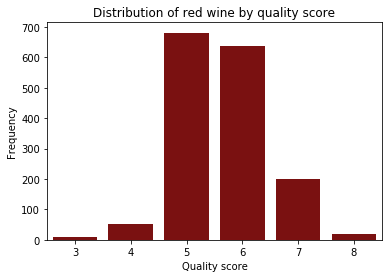

In [83]:
# distribution in quality
sns.countplot(x='quality', data=df, color="darkred")
plt.ylabel("Frequency")
plt.xlabel("Quality score")
plt.title("Distribution of red wine by quality score");

In order to make it more balanced and more interpretable, let's group the classes into two larger classes, namely low-quality (quality <= 5), high-quality (quality > 5). Low-quality will be denoted as 0 and high-quality will be denoted as 1.

In [84]:
df["quality"] = df["quality"].apply(lambda x: 0 if x <= 5 else 1)

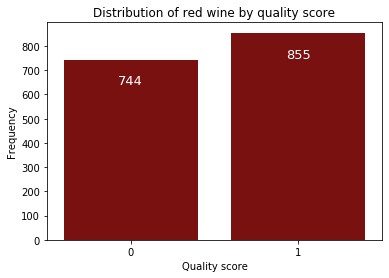

In [85]:
# new distribution in quality
ax = sns.countplot(x='quality', data=df, color="darkred")

ax.set_title('Survival in terms of gender', fontsize=20)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=13)

plt.ylabel("Frequency")
plt.xlabel("Quality score")
plt.title("Distribution of red wine by quality score");

In [86]:
print("The difference between two classes: ", df["quality"].value_counts()[1]-df["quality"].value_counts()[0])

The difference between two classes:  111


In [87]:
# dividing the dataset into input and output variables
X = df.iloc[:,:11]
y = df.iloc[:,-1]

In [88]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4


In [89]:
y.head()

0    0
1    0
2    0
3    1
4    0
Name: quality, dtype: int64

### 2.2 Model selection

For the following classification task, four difference classifiers will be used. They are:
1. Logistic Regression
2. K-nearest Neighbors (K-NN)
3. Kernelized SVM
4. Random Forest (random_state = 30)

### 2.3 Evaluation metric

Since our output variable is relatively balanced now we can use **Accuracy** to evaluate the performance of our models. However, to be on the safe side, they will also be compared to their **F1 scores**. Presumably, we want to see the same pattern in both accuracy and F1 scores. Here are the respective formulas for the two metrics:

$$
  Accuracy = \frac{(TP + TN)}{TP + FP + TN + FN}
$$
\
$$
  F1 = 2 \cdot \frac{(precision \cdot recall)}{precision + recall}, \ \text{where} \ precision = \frac{TP}{TP + FP} \ \text{and} \ recall = \frac{TP}{TP + FN}
$$

Also, in order to better understand how well the model generalizes to unseen data, **cross-validation** on 8 folds is utilized during all evaluation processes.

## 3. Experiments

In [90]:
# splitting the data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [91]:
y_test

803     1
124     0
350     1
682     0
1326    1
       ..
1259    1
1295    0
1155    0
963     1
704     0
Name: quality, Length: 320, dtype: int64

Logistic Regression, K-NN, and Kernelized SVM are sensitive towards feature scaling. Although Random Forest does not require feature scaling, it was decided to use scaled dataset for all models.

In [92]:
# scaling of input variables
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### 3.1 Modeling with default parameters

Let's start the modeling process with the default parameters provided by Sklearn developers. Note that Logistic Regression and Kernel-SVM use regularization by default. 

In [93]:
scores = []

# logistic regression
lr = LogisticRegression().fit(X_train_scaled, y_train)
lr_cv = cross_val_score(lr, X_train_scaled, y_train, cv=8, scoring='accuracy')

lr_pred_train = lr.predict(X_train_scaled)
lr_train_score = accuracy_score(y_train, lr_pred_train)

lr_pred_test = lr.predict(X_test_scaled)
lr_test_score = accuracy_score(y_test, lr_pred_test)
lr_test_f1_score = f1_score(y_test, lr_pred_test)

scores.append({
    "model": "logistic_reg",
    "accuracy_train": lr_train_score,
    "accuracy_test": lr_test_score,
    "accuracy_cv": lr_cv.mean(),
    "f1_test": lr_test_f1_score
})

# k-nearest neighbors
knn = KNeighborsClassifier().fit(X_train_scaled, y_train)
knn_cv = cross_val_score(knn, X_train_scaled, y_train, cv=8, scoring='accuracy')

knn_pred_train = knn.predict(X_train_scaled)
knn_train_score = accuracy_score(y_train, knn_pred_train)

knn_pred_test = knn.predict(X_test_scaled)
knn_test_score = accuracy_score(y_test, knn_pred_test)
knn_test_f1_score = f1_score(y_test, knn_pred_test)

scores.append({
    "model": "knn",
    "accuracy_train": knn_train_score,
    "accuracy_test": knn_test_score,
    "accuracy_cv": knn_cv.mean(),
    "f1_test": knn_test_f1_score
})

# kernelized svm
svm = SVC(kernel = 'rbf').fit(X_train_scaled, y_train)
svm_cv = cross_val_score(svm, X_train_scaled, y_train, cv=8, scoring='accuracy')

svm_pred_train = svm.predict(X_train_scaled)
svm_train_score = accuracy_score(y_train, svm_pred_train)

svm_pred_test = svm.predict(X_test_scaled)
svm_test_score = accuracy_score(y_test, svm_pred_test)
svm_test_f1_score = f1_score(y_test, svm_pred_test)

scores.append({
    "model": "kernel_svm",
    "accuracy_train": svm_train_score,
    "accuracy_test": svm_test_score,
    "accuracy_cv": svm_cv.mean(),
    "f1_test": svm_test_f1_score
})

# random forest
rf = RandomForestClassifier(random_state=30).fit(X_train_scaled, y_train)
rf_cv = cross_val_score(rf, X_train, y_train, cv=8, scoring='accuracy')

rf_pred_train = rf.predict(X_train_scaled)
rf_train_score = accuracy_score(y_train, rf_pred_train)

rf_pred_test = rf.predict(X_test_scaled)
rf_test_score = accuracy_score(y_test, rf_pred_test)
rf_test_f1_score = f1_score(y_test, rf_pred_test)

scores.append({
    "model": "random_forest",
    "accuracy_train": rf_train_score,
    "accuracy_test": rf_test_score,
    "accuracy_cv": rf_cv.mean(),
    "f1_test": rf_test_f1_score
})

# putting the results to a nice dataframe
df_scores = pd.DataFrame(scores, columns=["model", "accuracy_cv", "accuracy_train", "accuracy_test", "f1_test", "params"])
df_scores["params"]="default"
df_scores.style.background_gradient("Reds",subset=["accuracy_test","f1_test"])

,model,accuracy_cv,accuracy_train,accuracy_test,f1_test,params
0,logistic_reg,0.742863,0.75215,0.740625,0.760807,default
1,knn,0.720132,0.814699,0.70625,0.747312,default
2,kernel_svm,0.755426,0.802189,0.771875,0.790831,default
3,random_forest,0.797552,0.992181,0.75625,0.77193,default


As we can see from the table above, the best Accuracy and F1 scores go to **Kernelized SVM**. Let's now perform hyperparameter tuning with GridSearch to see if we can improve the performance of our models.

### 3.2 Hyperparameter tuning

In [94]:
# parameters for grid search
param_grid = {
    'logistic_reg': {
        'model': LogisticRegression(),
        'params': {'C': [0.1, 1, 3, 5],
                   'solver' : ['liblinear', 'saga']}},
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [5, 8, 10, 12, 16]}},
    
    'kernel_svm': {
        'model': SVC(kernel='rbf'),
        'params': {'C': [0.1, 1, 5, 10, 100],
                   'gamma': [0.1, 0.5, 1, 2, 5]}},
    
    'random_forest': {
        'model': RandomForestClassifier(random_state=30),
        'params': {'n_estimators': [10, 20, 25, 30],
                   'max_depth': [10, 20, 30, 40]}}}

# searching for the best parameters
best_param = []

for model_name, mp in param_grid.items():
    model = GridSearchCV(mp["model"], mp["params"], cv=8, scoring='accuracy')
    model.fit(X_train_scaled, y_train)
    best_param.append({
            "model" : model_name,
            "best_params": model.best_params_,
            "accuracy_cv": model.best_score_
    })

# putting the results to another nice dataframe
df_hyper_scores = pd.DataFrame(best_param, columns=["model", "best_params", "accuracy_cv"]).set_index('model')
df_hyper_scores

,best_params,accuracy_cv
model,,
logistic_reg,"{'C': 0.1, 'solver': 'liblinear'}",0.743550
knn,{'n_neighbors': 16},0.741204
kernel_svm,"{'C': 5, 'gamma': 0.5}",0.776388
random_forest,"{'max_depth': 30, 'n_estimators': 25}",0.818608


In [95]:
# calculating train and test scores with best set of parameters

# logistic regression ('C': 0.1, 'solver': 'liblinear')
lr_best = LogisticRegression(C=0.1, solver='liblinear')
lr_best.fit(X_train_scaled, y_train)

lr_best_pred_train = lr_best.predict(X_train_scaled)
lr_best_train_score = accuracy_score(y_train, lr_best_pred_train)

lr_best_pred_test = lr_best.predict(X_test_scaled)
lr_best_test_score = accuracy_score(y_test, lr_best_pred_test)
lr_best_test_f1_score = f1_score(y_test, lr_best_pred_test)

df_hyper_scores.loc["logistic_reg", "accuracy_train"] = lr_best_train_score
df_hyper_scores.loc["logistic_reg", "accuracy_test"] = lr_best_test_score
df_hyper_scores.loc["logistic_reg", "f1_test"] = lr_best_test_f1_score

# k-nearest neighbors ('n_neighbors': 16)
knn_best = KNeighborsClassifier(n_neighbors=16)
knn_best.fit(X_train_scaled, y_train)

knn_best_pred_train = knn_best.predict(X_train_scaled)
knn_best_train_score = accuracy_score(y_train, knn_best_pred_train)

knn_best_pred_test = knn_best.predict(X_test_scaled)
knn_best_test_score = accuracy_score(y_test, knn_best_pred_test)
knn_best_test_f1_score = f1_score(y_test, knn_best_pred_test)

df_hyper_scores.loc["knn", "accuracy_train"] = knn_best_train_score
df_hyper_scores.loc["knn", "accuracy_test"] = knn_best_test_score
df_hyper_scores.loc["knn", "f1_test"] = knn_best_test_f1_score

# kernelized svm ('C': 5, 'gamma': 0.5)
svm_best = SVC(kernel='rbf', C=5, gamma=0.5)
svm_best.fit(X_train_scaled, y_train)

svm_best_pred_train = svm_best.predict(X_train_scaled)
svm_best_train_score = accuracy_score(y_train, svm_best_pred_train)

svm_best_pred_test = svm.predict(X_test_scaled)
svm_best_test_score = accuracy_score(y_test, svm_best_pred_test)
svm_best_test_f1_score = f1_score(y_test, svm_best_pred_test)

df_hyper_scores.loc["kernel_svm", "accuracy_train"] = svm_best_train_score
df_hyper_scores.loc["kernel_svm", "accuracy_test"] = svm_best_test_score
df_hyper_scores.loc["kernel_svm", "f1_test"] = svm_best_test_f1_score

# random forest ('max_depth': 30, 'n_estimators': 25)
rf_best = RandomForestClassifier(max_depth=30, n_estimators=25, random_state=30)
rf_best.fit(X_train_scaled, y_train)

rf_best_pred_train = rf_best.predict(X_train_scaled)
rf_best_train_score = accuracy_score(y_train, rf_best_pred_train)

rf_best_pred_test = rf_best.predict(X_test_scaled)
rf_best_test_score = accuracy_score(y_test, rf_best_pred_test)
rf_best_test_f1_score = f1_score(y_test, rf_best_pred_test)

df_hyper_scores.loc["random_forest", "accuracy_train"] = rf_best_train_score
df_hyper_scores.loc["random_forest", "accuracy_test"] = rf_best_test_score
df_hyper_scores.loc["random_forest", "f1_test"] = rf_best_test_f1_score

In [96]:
# some cosmetics for future manipulations with df_hyper_scores
df_hyper_scores.insert(5, "params", "tuned")
df_hyper_scores = df_hyper_scores.drop("best_params", axis=1).reset_index()

In [97]:
# merging the scores of default models and the scores of hupertuned models
merged_scores = pd.concat([df_hyper_scores, df_scores], ignore_index=True).sort_values(by=['model']).reset_index(drop=True)
merged_scores.style.background_gradient("Reds",subset=["accuracy_test","f1_test"])

,model,accuracy_cv,accuracy_train,accuracy_test,f1_test,params
0,kernel_svm,0.776388,0.97498,0.771875,0.790831,tuned
1,kernel_svm,0.755426,0.802189,0.771875,0.790831,default
2,knn,0.741204,0.767005,0.728125,0.752137,tuned
3,knn,0.720132,0.814699,0.70625,0.747312,default
4,logistic_reg,0.74355,0.749805,0.74375,0.761628,tuned
5,logistic_reg,0.742863,0.75215,0.740625,0.760807,default
6,random_forest,0.818608,0.999218,0.790625,0.81337,tuned
7,random_forest,0.797552,0.992181,0.75625,0.77193,default


- The table above shows that hyperparameter tuning increased the scores of **Logistic Regression**, **K-NN**, and **Random Forest** models, however, it did not affect the scores of the **Kernelized SVM** model in any way. So, we will be using tuned hyperparameters for our models and will refer to them as *best models*.
- One might also note that now **Random Forest** has the highest scores compared to the other three models.

### 3.3 Checking for overfitting

- It is difficult to tell whether the scores after hyperparameter tuning are high enough. This is because if the model is over/underfitting the training dataset, its performance on the unseen dataset will become poor. 
- In order to see if there is room for further improvement, it is important to investigate whether the model is over/underfitting. For this task, performing an *analysis of learning dynamics* might be helpful. The analysis is performed by varying a key model hyperparameter and evaluating the model performance on the train and cross-validation sets for each configuration. The results are plotted on a *learning curve* which is defined by *Accuracy Score (train and cross-validation) vs Model Complexity*.

#### Logistic Regression

There is no need to analyze the learning dynamics of a Logistic Regression because it is a linear classifier that does not have hyperparameters making the model more complex. Logistic Regression cannot over/underfit.

#### K-Nearest Neighbors (K-NN)

The complexity of K-NN depends on the *number of neighbors*. Smaller numbers usually result in more complex models that lead to overfitting, whereas larger numbers (close to the number of instances) might conversely lead to underfitting.

In [98]:
knn_train_scores = []
knn_cv_scores = []

# values for k-neighbors 
neighbors = np.arange(1, 41, 1)

for k in neighbors:
    # fit the model
    knn_clf = KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, y_train)
    
    # evaluate on the CV
    knn_clf_cv = cross_val_score(knn_clf, X_train_scaled, y_train, cv=8, scoring='accuracy')
    knn_cv_scores.append(knn_clf_cv.mean())
    
    # evaluate on the train set
    knn_clf_train = knn_clf.predict(X_train_scaled)
    knn_clf_train_score = accuracy_score(y_train, knn_clf_train)
    knn_train_scores.append(knn_clf_train_score)
    
    # summary
    print('k: %d, train: %.3f, cv: %.3f' % (k, knn_clf_train_score, knn_clf_cv.mean()))

k: 1, train: 1.000, cv: 0.751
k: 2, train: 0.878, cv: 0.701
k: 3, train: 0.861, cv: 0.723
k: 4, train: 0.831, cv: 0.706
k: 5, train: 0.815, cv: 0.720
k: 6, train: 0.797, cv: 0.722
k: 7, train: 0.795, cv: 0.719
k: 8, train: 0.783, cv: 0.733
k: 9, train: 0.779, cv: 0.732
k: 10, train: 0.787, cv: 0.730
k: 11, train: 0.784, cv: 0.723
k: 12, train: 0.784, cv: 0.733
k: 13, train: 0.774, cv: 0.730
k: 14, train: 0.765, cv: 0.742
k: 15, train: 0.773, cv: 0.730
k: 16, train: 0.767, cv: 0.741
k: 17, train: 0.769, cv: 0.729
k: 18, train: 0.768, cv: 0.727
k: 19, train: 0.761, cv: 0.724
k: 20, train: 0.765, cv: 0.727
k: 21, train: 0.758, cv: 0.724
k: 22, train: 0.762, cv: 0.722
k: 23, train: 0.758, cv: 0.723
k: 24, train: 0.758, cv: 0.731
k: 25, train: 0.753, cv: 0.725
k: 26, train: 0.755, cv: 0.730
k: 27, train: 0.753, cv: 0.719
k: 28, train: 0.756, cv: 0.730
k: 29, train: 0.752, cv: 0.726
k: 30, train: 0.753, cv: 0.733
k: 31, train: 0.751, cv: 0.728
k: 32, train: 0.756, cv: 0.731
k: 33, train: 0.7

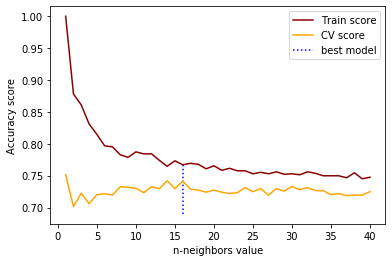

In [99]:
# visualizing complexity
plt.plot(neighbors, knn_train_scores, color="darkred",label='Train score')
plt.plot(neighbors, knn_cv_scores, color="orange", label='CV score')
plt.vlines(16, 0.69, 0.77, color='blue', linestyles='dotted', label="best model")
plt.xlabel("n-neighbors value")
plt.ylabel("Accuracy score")
plt.legend();

- As we can see from the graph, cross-validation scores start gradually decreasing approximately from k = 20.
- Recall that the best K-NN model was the one with k = 16. It is marked by a blue dotted vertical line on the graph. We can observe that our best model does not overfit because the cross-validation score starts to decrease only after k = 20. It also does not underfitted because the cross-validation score for k = 16 is one of the highest ones.
- One should note that training score also decreases as k starts to increase. It is probably due to the fact that the training process in K-NN is just storing the data, therefore, K-NN will perform perfectly on the training data only when k = 1.

#### Kernelized SVM

Overall, Kernelized SVM has one hyperparameter that directly affects the complexity of the model, namely kernel coefficient *gamma*. So we will use it to plot learning curve to see if there is any overfitting present in our model. We will fix C = 5 because hyperparameter tuning showed it to be the 'best' hyperparameter. 

In [100]:
# evaluating at fixed C (C=5) and different values of gamma
svm_gamma_train_scores = []
svm_gamma_cv_scores = []
gamma = np.linspace(0.01, 3, num=30)

for g in gamma: 
    # fit the model
    svm_gamma_clf = SVC(kernel='rbf', C=5, gamma=g).fit(X_train_scaled, y_train)
    
    # evaluate on the CV
    svm_gamma_clf_cv = cross_val_score(svm_gamma_clf, X_train_scaled, y_train, cv=8, scoring='accuracy')
    svm_gamma_cv_scores.append(svm_gamma_clf_cv.mean())
    
    # evaluate on the train set
    svm_gamma_clf_train = svm_gamma_clf.predict(X_train_scaled)
    svm_gamma_clf_train_score = accuracy_score(y_train, svm_gamma_clf_train)
    svm_gamma_train_scores.append(svm_gamma_clf_train_score)
    
    # summary
    print('gamma: %.3f, train: %.3f, cv: %.3f' % (g, svm_gamma_clf_train_score, svm_gamma_clf_cv.mean()))

gamma: 0.010, train: 0.766, cv: 0.749
gamma: 0.113, train: 0.846, cv: 0.769
gamma: 0.216, train: 0.903, cv: 0.768
gamma: 0.319, train: 0.942, cv: 0.769
gamma: 0.422, train: 0.967, cv: 0.776
gamma: 0.526, train: 0.977, cv: 0.773
gamma: 0.629, train: 0.987, cv: 0.769
gamma: 0.732, train: 0.992, cv: 0.768
gamma: 0.835, train: 0.995, cv: 0.765
gamma: 0.938, train: 0.996, cv: 0.765
gamma: 1.041, train: 0.995, cv: 0.762
gamma: 1.144, train: 0.996, cv: 0.756
gamma: 1.247, train: 0.996, cv: 0.753
gamma: 1.350, train: 0.996, cv: 0.750
gamma: 1.453, train: 0.996, cv: 0.747
gamma: 1.557, train: 0.997, cv: 0.748
gamma: 1.660, train: 0.998, cv: 0.747
gamma: 1.763, train: 0.998, cv: 0.745
gamma: 1.866, train: 0.998, cv: 0.742
gamma: 1.969, train: 0.999, cv: 0.741
gamma: 2.072, train: 0.999, cv: 0.741
gamma: 2.175, train: 1.000, cv: 0.741
gamma: 2.278, train: 1.000, cv: 0.737
gamma: 2.381, train: 1.000, cv: 0.734
gamma: 2.484, train: 1.000, cv: 0.733
gamma: 2.588, train: 1.000, cv: 0.728
gamma: 2.691

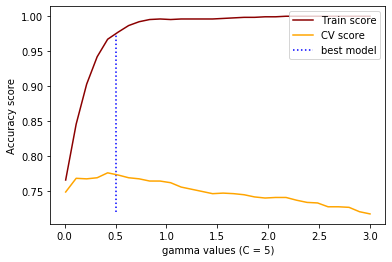

In [101]:
# visualizing complexity
plt.figure()
plt.plot(gamma, svm_gamma_train_scores, color='darkred', label='Train score')
plt.plot(gamma, svm_gamma_cv_scores, color='orange', label='CV score')
plt.vlines(0.5, 0.72, 0.975, color='blue', linestyles='dotted', label="best model")
plt.xlabel('gamma values (C = 5)')
plt.ylabel('Accuracy score')
plt.legend(loc='upper right', fontsize=10);

When evaluating Kernelized SVM with different gammas and fixed C = 5, we can observe that overfitting starts approximately from gamma = 0.6. This is because the cross-validation score starts to decrease, while the training score starts to increase.\
From hyperparameter-tuning, the best performing Kernelized SVM was at C = 5 and gamma = 0.5. They are denoted by blue dotted vertical line. Since the 'best' gamma is lower than 0.6 most probably our model does not overfit. It aldo does not underfit because train accuracy is one of the highest ones.

#### Random Forest

Since there are two important hyperparameters in Random Forest that affect model complexity, it is difficult to interpret them simultaneously in one learning curve. In order to still show the dependence between performance and model complexity, it was decided to make two separate graphs. In each graph, one of the parameters will be varying, and the other one will be fixed (the value for the fixed parameter will be taken from the best-performing model identified during hyperparameter tuning).\
\
The two important hyperparameters are *maximum depth* and *number of estimators* (*bootstrap* and *max_features* were not evaluated due to computational and time complexities). Let's evaluate and plot the two learning curves.

In [102]:
# evaluating at fixed max_depth (max_depth=30) and different values of n_estimators
rf_n_train_scores = []
rf_n_cv_scores = []
n_estimators = np.arange(1, 61, 2, dtype=int)

for n in n_estimators:
    # fit the model
    rf_n_clf = RandomForestClassifier(max_depth=30, n_estimators=n, random_state=30).fit(X_train_scaled, y_train)
    
    # evaluate on the CV
    rf_n_clf_cv = cross_val_score(rf_n_clf, X_train_scaled, y_train, cv=8, scoring='accuracy')
    rf_n_cv_scores.append(rf_n_clf_cv.mean())
    
    # evaluate on the train set
    rf_n_clf_train = rf_n_clf.predict(X_train_scaled)
    rf_n_clf_train_score = accuracy_score(y_train, rf_n_clf_train)
    rf_n_train_scores.append(rf_n_clf_train_score)
    
    # summary
    print('n_estim: %d, train: %.3f, cv: %.3f' % (n, rf_n_clf_train_score, rf_n_clf_cv.mean()))

# evaluating at fixed n_estimators (n_estimators=25) and different values of max_depths
rf_depth_train_scores = []
rf_depth_cv_scores = []
depths = np.arange(1, 61, 2, dtype=int)

for d in depths: 
    # fit the model
    rf_depth_clf = RandomForestClassifier(max_depth=d, n_estimators=25, random_state=30).fit(X_train_scaled, y_train)
    
    # evaluate on the CV
    rf_depth_clf_cv = cross_val_score(rf_depth_clf, X_train_scaled, y_train, cv=8, scoring='accuracy')
    rf_depth_cv_scores.append(rf_depth_clf_cv.mean())
    
    # evaluate on the train set
    rf_depth_clf_train = rf_depth_clf.predict(X_train_scaled)
    rf_depth_clf_train_score = accuracy_score(y_train, rf_depth_clf_train)
    rf_depth_train_scores.append(rf_depth_clf_train_score)
    
    # summary
    print('depth: %d, train: %.3f, cv: %.3f' % (d, rf_depth_clf_train_score, rf_depth_clf_cv.mean()))

n_estim: 1, train: 0.894, cv: 0.724
n_estim: 3, train: 0.951, cv: 0.778
n_estim: 5, train: 0.972, cv: 0.785
n_estim: 7, train: 0.986, cv: 0.782
n_estim: 9, train: 0.991, cv: 0.798
n_estim: 11, train: 0.997, cv: 0.802
n_estim: 13, train: 0.995, cv: 0.801
n_estim: 15, train: 0.996, cv: 0.809
n_estim: 17, train: 0.998, cv: 0.812
n_estim: 19, train: 0.999, cv: 0.816
n_estim: 21, train: 0.997, cv: 0.817
n_estim: 23, train: 0.998, cv: 0.819
n_estim: 25, train: 0.999, cv: 0.819
n_estim: 27, train: 1.000, cv: 0.819
n_estim: 29, train: 0.999, cv: 0.809
n_estim: 31, train: 0.999, cv: 0.812
n_estim: 33, train: 0.999, cv: 0.813
n_estim: 35, train: 1.000, cv: 0.815
n_estim: 37, train: 1.000, cv: 0.811
n_estim: 39, train: 1.000, cv: 0.814
n_estim: 41, train: 1.000, cv: 0.815
n_estim: 43, train: 1.000, cv: 0.812
n_estim: 45, train: 1.000, cv: 0.811
n_estim: 47, train: 1.000, cv: 0.812
n_estim: 49, train: 1.000, cv: 0.814
n_estim: 51, train: 1.000, cv: 0.814
n_estim: 53, train: 1.000, cv: 0.812
n_esti

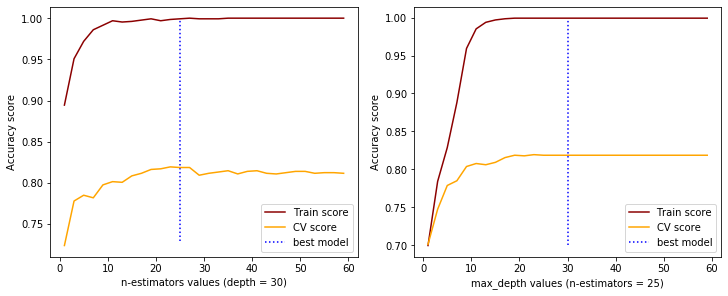

In [103]:
# visualizing complexity
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4))
ax[0].plot(n_estimators, rf_n_train_scores, color='darkred', label='Train score')
ax[0].plot(n_estimators, rf_n_cv_scores, color='orange', label='CV score')
ax[0].vlines(25, 0.73, 0.9995, color='blue', linestyles='dotted', label="best model")
ax[0].set_xlabel('n-estimators values (depth = 30)')
ax[0].set_ylabel('Accuracy score')
ax[0].legend(loc='lower right', fontsize=10)

ax[1].plot(depths, rf_depth_train_scores, color='darkred', label='Train score')
ax[1].plot(depths, rf_depth_cv_scores, color='orange', label='CV score')
ax[1].vlines(30, 0.7, 0.998, color='blue', linestyles='dotted', label="best model")
ax[1].set_xlabel('max_depth values (n-estimators = 25)')
ax[1].set_ylabel('Accuracy score')
ax[1].legend(loc='lower right', fontsize=10);

- Left-graph: When evaluating Random Forest with different n-estimators and fixed depth = 30, we can observe that overfitting starts approximately from n-estimators = 29. This is because the cross-validation score starts to decrease, while the training score starts to increase.
- Right-graph: When evaluating Random Forest with different depths and fixed n-estimators = 25, we cannot see clear overfitting patterns because, after depth = 19, both training and cross-validation scores do not change.
- From hyperparameter-tuning, the best performing Random Forest was at depth = 30 and n-estimators = 25. They are denoted by blue dotted vertical lines. By looking at the learning curves, we can conclude that our best model probably does not over/underfit. This is because the left learning curve at n-estimators = 25 (depth = 30) is not in the over/underfitting zone. The same goes for the right learning curve, at depth = 30 (n-estimators = 25) it also does not seem to over/underfit.

## 4. Analysis

### 4.1 Error analysis

### ROC Curves

In order to see whether our models perform better than any other dummy classifier, let's plot ROC Curves with corresponding AUC values.

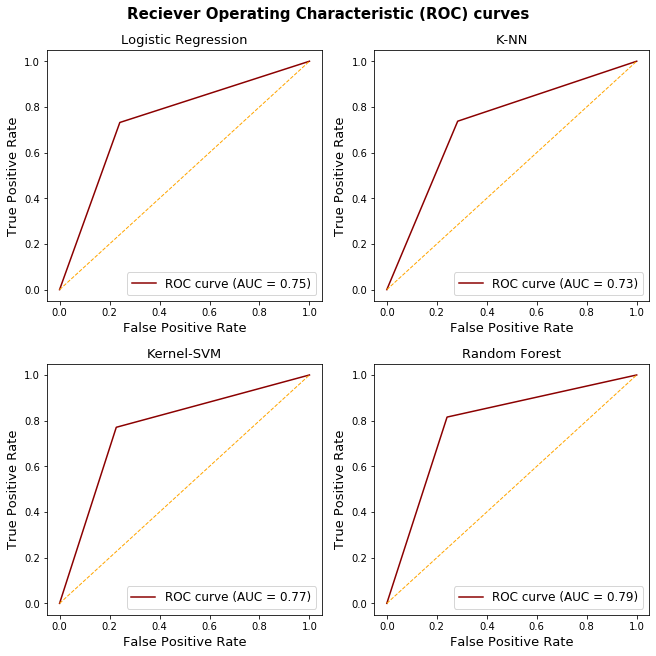

In [104]:
# ROC curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=True, figsize=(9,9))
fig.suptitle('Reciever Operating Characteristic (ROC) curves', fontweight='bold', fontsize=15)

preds = [lr_best_pred_test, knn_best_pred_test, svm_best_pred_test, rf_best_pred_test]
models = ["Logistic Regression", "K-NN", "Kernel-SVM", "Random Forest"]
axs = [ax1, ax2, ax3, ax4]

for i in range(4):
    fpr, tpr, _ = roc_curve(y_test, preds[i])
    roc_auc = auc(fpr, tpr)
    
    axs[i].plot(fpr, tpr, label='ROC curve (AUC = {:0.2f})'.format(roc_auc), color='darkred')
    axs[i].plot([0, 1], [0, 1], color='orange', lw=1, linestyle='--')
    axs[i].legend(loc='lower right', fontsize=12)
    
    axs[i].set_xlabel('False Positive Rate', fontsize=13)
    axs[i].set_ylabel('True Positive Rate', fontsize=13)
    axs[i].set_title("{}".format(models[i]), fontsize=13);

The ROC curves of all four models are relatively close to the top left of the graph suggesting that their predictive powers are pretty good. *AUC values* are not 0.5, which suggests that our models perform better than a dummy classifier.

### Confusion matrix

In order to analyze the errors, a good practice is to investigate *confusion matrix*. In confusion matrix, positive is 1 (high-quality wine), and negative is 0 (low-quality wine).

In [105]:
df_hyper_scores = df_hyper_scores.drop("params", axis=1).set_index("model")
model_names = ["logistic_reg","knn","kernel_svm","random_forest"]

In [106]:
# adding confusion matrix results to df_hyper_scores
for i in range(4):
    df_hyper_scores.loc[model_names[i], "TN"] = confusion_matrix(y_test, preds[i])[0,0]
    df_hyper_scores.loc[model_names[i], "FP"] = confusion_matrix(y_test, preds[i])[0,1]
    df_hyper_scores.loc[model_names[i], "TP"] = confusion_matrix(y_test, preds[i])[1,1]
    df_hyper_scores.loc[model_names[i], "FN"] = confusion_matrix(y_test, preds[i])[1,0]

df_hyper_scores

,accuracy_cv,accuracy_train,accuracy_test,f1_test,TN,FP,TP,FN
model,,,,,,,,
logistic_reg,0.743550,0.749805,0.743750,0.761628,107.0,34.0,131.0,48.0
knn,0.741204,0.767005,0.728125,0.752137,101.0,40.0,132.0,47.0
kernel_svm,0.776388,0.974980,0.771875,0.790831,109.0,32.0,138.0,41.0
random_forest,0.818608,0.999218,0.790625,0.813370,107.0,34.0,146.0,33.0


In [107]:
# imbalance in y_test
print("The number of high-quality wines:", Counter(y_test)[1])
print("The number of low-quality wines:", Counter(y_test)[0])

The number of high-quality wines: 179
The number of low-quality wines: 141


Making conclusions just looking at FP and FN values intuitively seems to be not correct because there is some class imbalance in y_test. It would be better to look at the False Positive Rate (FPR) and False Negative Rate (FNR).

In [108]:
df_hyper_scores["FPR"] = df_hyper_scores["FP"]/(df_hyper_scores["FP"]+df_hyper_scores["TN"])
df_hyper_scores["FNR"] = df_hyper_scores["FN"]/(df_hyper_scores["TP"]+df_hyper_scores["FN"])
df_hyper_scores.style.background_gradient("Reds", subset=["FPR","FNR"], axis=1)

,accuracy_cv,accuracy_train,accuracy_test,f1_test,TN,FP,TP,FN,FPR,FNR
model,,,,,,,,,,
logistic_reg,0.74355,0.749805,0.74375,0.761628,107,34,131,48,0.241135,0.268156
knn,0.741204,0.767005,0.728125,0.752137,101,40,132,47,0.283688,0.26257
kernel_svm,0.776388,0.97498,0.771875,0.790831,109,32,138,41,0.22695,0.22905
random_forest,0.818608,0.999218,0.790625,0.81337,107,34,146,33,0.241135,0.184358


From the above table, we can observe that overall **Logistic Regression** and **Kernelized-SVM** find predicting high-quality wines more difficult than predicting low-quality wine. This is because FNR is higher than FPR. Whereas **K-NN** and **Random Forest** conversely find predicting low-quality wines more difficult than predicting high-quality wines because FPR is higher than FNR in these models. This may be due to the fact that both Logistic Regression and Kernelized SVM used regularization, whereas K-NN and Random Forest did not.\
\
From the above summary table, we can observe that all four models perform *decently* well on the test set. Their accuracy scores range approximately from 0.72 to 0.79. While investigating the presence of overfitting in these models, it can be noticed that further hyperparameter tuning probably will not change the accuracy scores. This is most likely due to problems with the dataset (e.g. too many outlieres, unnecessary input variables).

### Feature Importance

Due to the specificity of K-NN and Kernelized SVM, conducting an investigation on feature importance is possible only with Logistic Regression and Random Forest.

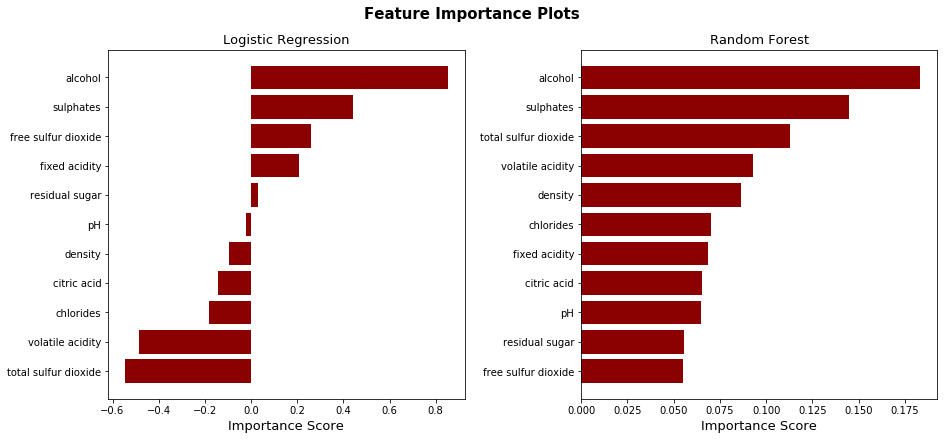

In [109]:
# feature importance plots
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(13,6))
fig.suptitle('Feature Importance Plots', fontweight='bold', fontsize=15)
# models = [, "K-NN", "Kernel-SVM", "Random-Forest"]

features = df.columns[:-1]

# Logistic Regression
lr_importance = lr_best.coef_[0]
sorted_lr_idx = lr_importance.argsort()
axs[0].barh(features[sorted_lr_idx], lr_importance[sorted_lr_idx], color="darkred")
axs[0].set_xlabel('Importance Score', fontsize=13)
axs[0].set_title("Logistic Regression", fontsize=13)


# Random Forest
rf_importance = rf_best.feature_importances_
sorted_rf_idx = rf_importance.argsort()
axs[1].barh(features[sorted_rf_idx], rf_importance[sorted_rf_idx], color="darkred")
axs[1].set_xlabel('Importance Score', fontsize=13)
axs[1].set_title("Random Forest", fontsize=13);

Looking at the plot for Logistic Regression one can notice both positive and negative Importance Scores. The positive scores indicate a feature that predicts high-quality wines, whereas the negative scores indicate a feature that predicts low-quality wines. Overall, *pH* and *Residual sugar* contribute the least to Logistic Regression. For Random Forest, three of the most important features are *Alcohol*, *Sulphates*, and *Total sulfur dioxide*.

### 4.2 Further experiments

There are actually other different methods that could boost the performance of our models. The following methods are suggested for further experiments:
1. Trying more complex classifiers (e.g. XGBoost, LightGBM);
2. Increasing the dataset (e.g. adding white-wine dataset);
3. Handling outliers (from Project-1, it was observed that input variables suffer from severe outliers);
4. Removing unnecessary input variables (e.g. the ones that have the smallest correlation with *quality*).

## 5. Discussion

### Main findings

Our main goal in this project was to construct a decent classifier that would predict red wine quality based on its chemical properties. First, we tried classifiers such as Logistic Regression, K-NN, Kernelized SVM, and Random Forest with default hyperparameters set by Sklearn developer. They were able to achieve decent Accuracy scores, however,  Hyperparameter tuning via GridSearch managed to improve the scores a little bit more. The models with the improved hyperparameters were further checked for over/underfitting, and neither of them seemed to over/underfit. Following this, the error analysis showed that some models struggle to predict low-quality wines, and some struggle to predict high-quality wines.

### Limitations

There are several limitations with this project:
1. The full potential of hyperparameter tuning was not utilized. Since the CPU has a restricted amount of power, adding more hyperparameters to evaluate also adds to time complexity because there will be more hyperparameter combinations. Therefore, for example, in Random Forest other important hyperparameters such as *bootstrap* or *max_features* were not checked. 
2. Dividing the dataset into "low-quality" and "high-quality" wines might have led to inaccurate results. Such rapid division into two large subgroups neglects some key details in the quality of the wine. Maybe it would have been better to divide the dataset into three subgroups, namely "low", "medium", and "high-quality" red wines.
3. There are several problems with the dataset that could have negatively affected the model performance. For example, the large number of outliers present in the dataset or unnecessary input variables.

## 6. Conclusion 

Overall, out of four models, Random Forest gave the best Accuracy score (= 0.791). The second best model was Kernelized SVM (= 0.772), the third was Logistic Regression (= 0.743), and the last one in a list was K-NN (= 0.728). However, these results are true only for a specific train/test split (in this project the split was 0.2). If the split will change say to 0.1, the results might be different.